# Introducción

La predicción temprana de accidentes cerebrovasculares es un problema crítico dentro del ámbito de la salud pública. Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular constituye la segunda causa de muerte a nivel mundial y representa aproximadamente el 11% del total de fallecimientos globales. La posibilidad de anticipar estos eventos a partir de información clínica y demográfica habilita herramientas de prevención e intervención temprana.

En este trabajo práctico se desarrolla un modelo de aprendizaje automático orientado a predecir la probabilidad de que un paciente sufra un accidente cerebrovascular, utilizando como insumo el Stroke Prediction Dataset publicado en Kaggle. El objetivo es explorar las variables disponibles, realizar el preprocesamiento necesario, comparar distintas alternativas de modelado y finalmente seleccionar un algoritmo que permita obtener un desempeño robusto y clínicamente útil.

Fuente del dataset:
Federico Soriano, Stroke Prediction Dataset, Kaggle (2021).
Disponible en: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

## Miembros del grupo
- Maximiliano Christener
- Ronald Uthurralt
- Juan Pablo Skobalski
- Luis Díaz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostClassifier
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline  # uso este para aplicar SMOTE en el pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, make_scorer, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns


# AGREGO ESTO DESPUES DE HABER CORRIDO EL CODIGO COMPLETO Y EVALUADO TODOS LOS WARNINGS, SU OBJETIVO ES OCULTAR EL WARNING EN EL precision_recall_curve
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [2]:

def find_threshold(y_true, y_proba, beta=2, n_thresholds=200):
    """
    Busca el threshold óptimo que maximiza F-beta (por defecto F2).
    """
    
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    scores = []
    
    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        score = fbeta_score(y_true, y_pred_thr, beta=beta)
        scores.append(score)
    
    best_idx = int(np.argmax(scores))
    best_threshold = thresholds[best_idx]
    best_fbeta = scores[best_idx]
    
    return best_threshold, best_fbeta

El dataset contiene información de pacientes, tanto datos demográficos como factores de riesgo clínicos. Cada fila representa un individuo y cada columna un atributo relevante para la predicción. Las variables principales son:

Variables demográficas:

* gender: género del paciente
* age: edad del paciente
* ever_married: si alguna vez estuvo casado
* work_type: tipo de ocupación
* Residence_type: tipo de residencia (urbana o rural)

Variables clínicas:

* hypertension: presencia de hipertensión
* heart_disease: presencia de enfermedad cardíaca
* avg_glucose_level: nivel promedio de glucosa en sangre
* bmi: índice de masa corporal

Hábitos y estilo de vida:
* smoking_status: categoría de consumo de tabaco

Variable objetivo:

* stroke: indica si el paciente sufrió un accidente cerebrovascular (1) o no (0)

El dataset presenta un desbalance significativo, con un porcentaje muy bajo de casos positivos (5%), lo cual condiciona el tipo de modelos y métricas a utilizar.


# EDA

In [3]:
file_path = "data/healthcare-dataset-stroke-data.csv"

df = pd.read_csv(file_path)

In [4]:
# Configuracion general de graficos
sns.set(style="whitegrid", palette="deep", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nInformación general:")
df.info()

print("\nValores faltantes por columna:")
print(df.isna().sum())


print(df['work_type'])

Dimensiones del dataset: (5110, 12)

Primeras filas:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Valores faltantes por columna:
id                     0
gender                 0
age                    0
hypertension           0
hea

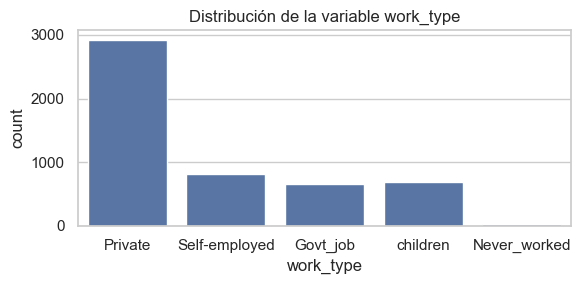

In [6]:
plt.figure(figsize=(6, 3))
sns.countplot(x='work_type', data=df)
plt.title('Distribución de la variable work_type')
plt.tight_layout()
plt.show()

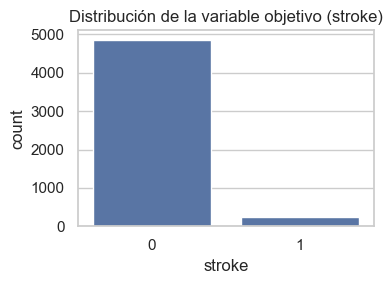

In [7]:
plt.figure(figsize=(4, 3))
sns.countplot(x='stroke', data=df)
plt.title('Distribución de la variable objetivo (stroke)')
plt.tight_layout()
plt.show()

### Distribucion de edad, nivel de glucosa y BMI


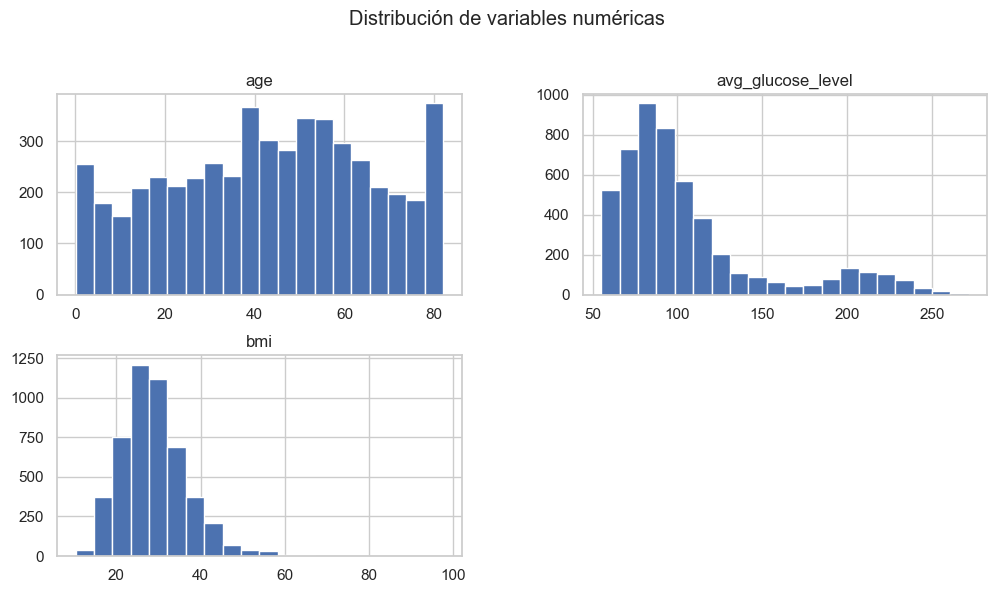

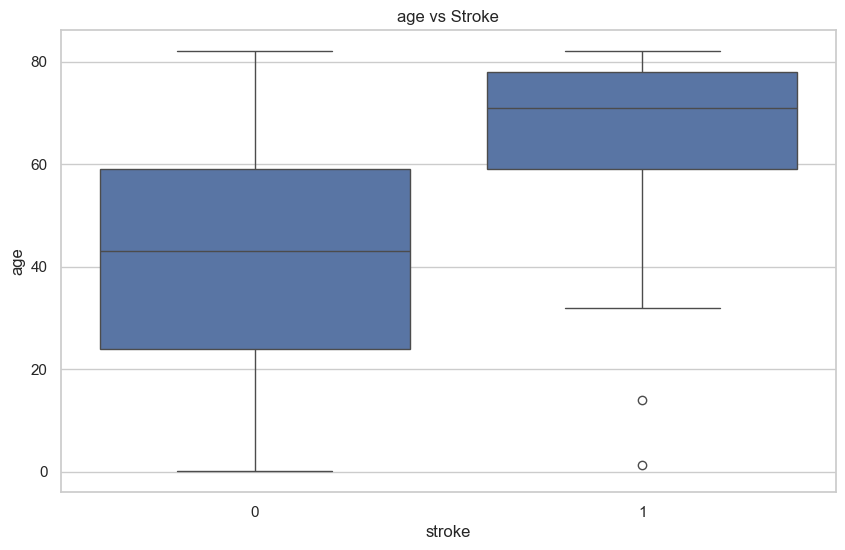

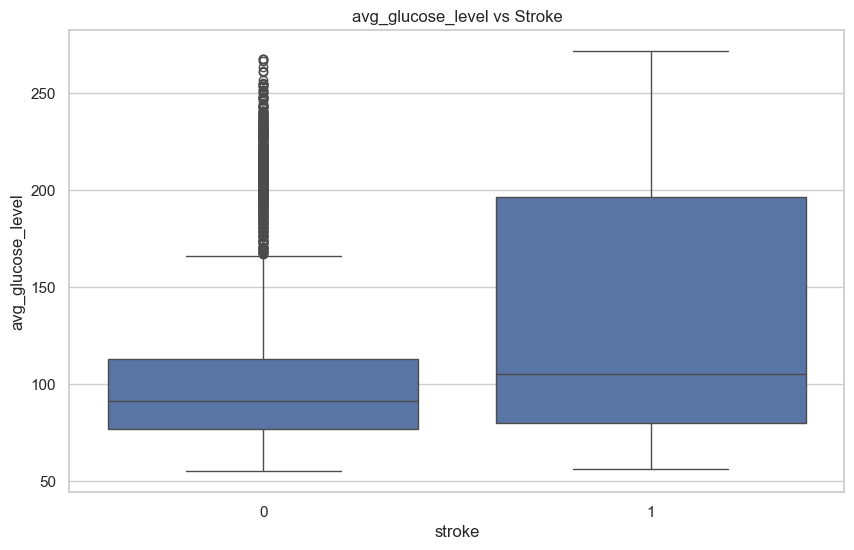

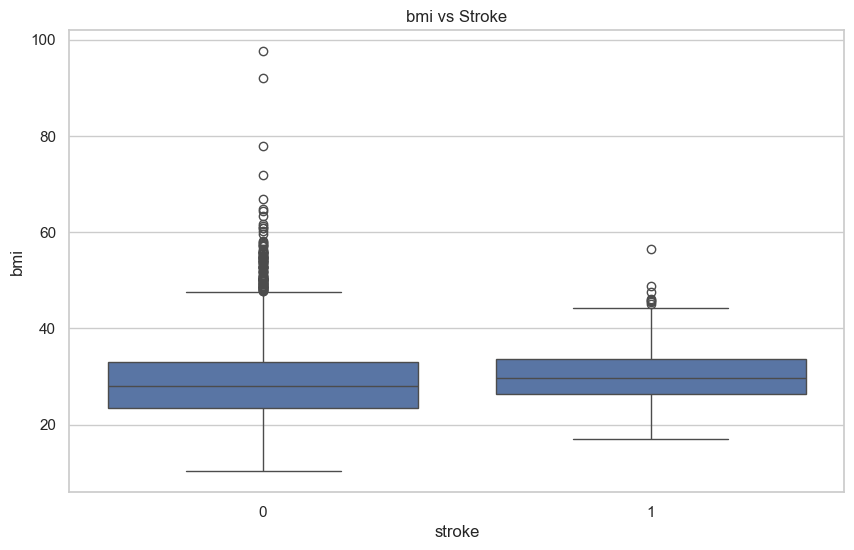

In [8]:
num_vars = ['age', 'avg_glucose_level', 'bmi']
df[num_vars].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribución de variables numéricas', y=1.02)
plt.show()

# comparanmos stroke vs variables numericas
for col in num_vars:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} vs Stroke')
    plt.show()

### Matriz de correlacion entre variables numericas

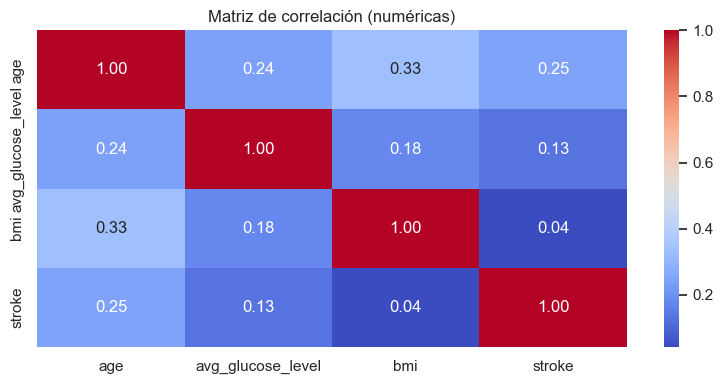

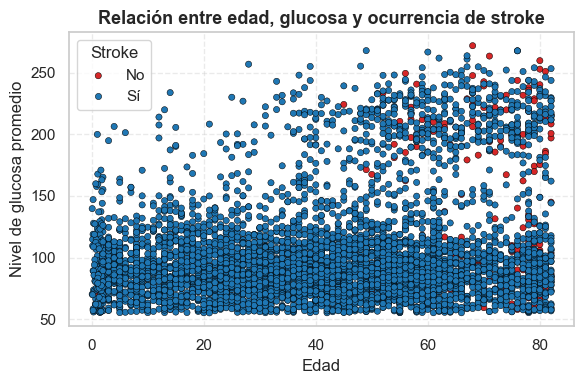

In [9]:
plt.figure(figsize=(8, 4))
corr = df[num_vars + ['stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación (numéricas)')
plt.tight_layout()
plt.show()

# Relacion entre edad y nivel de glucosa, coloreado por stroke
plt.figure(figsize=(6, 4)) 
sns.scatterplot(
    data=df,
    x='age',
    y='avg_glucose_level',
    hue='stroke',
    palette={0: '#1f77b4', 1: '#d62728'},  # azul fuerte para 0, rojo intenso para 1
    alpha=1,
    edgecolor='black',
    s=20  # tamaño de puntos
)
plt.title('Relación entre edad, glucosa y ocurrencia de stroke', fontsize=13, weight='bold')
plt.xlabel('Edad')
plt.ylabel('Nivel de glucosa promedio')
plt.legend(title='Stroke', labels=['No', 'Sí'])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Distribuciones categoricas vs Target

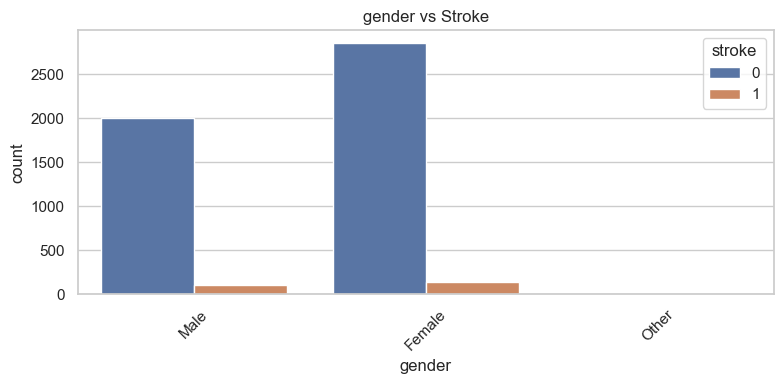

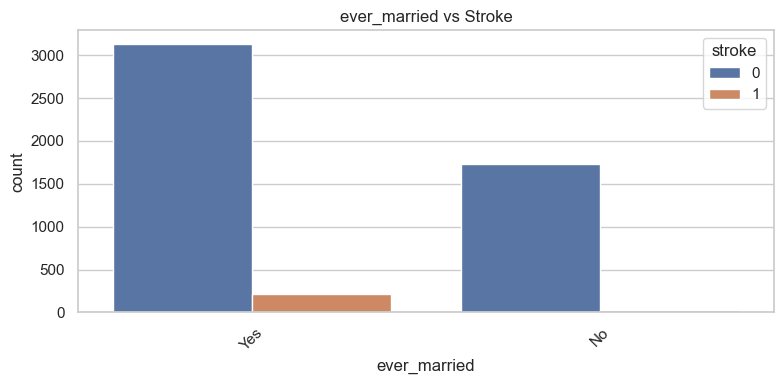

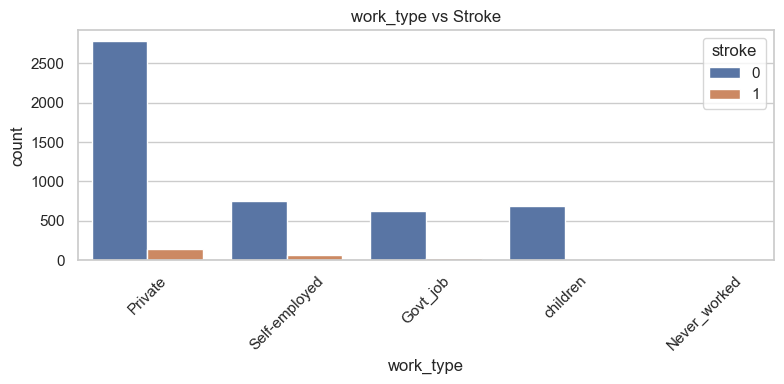

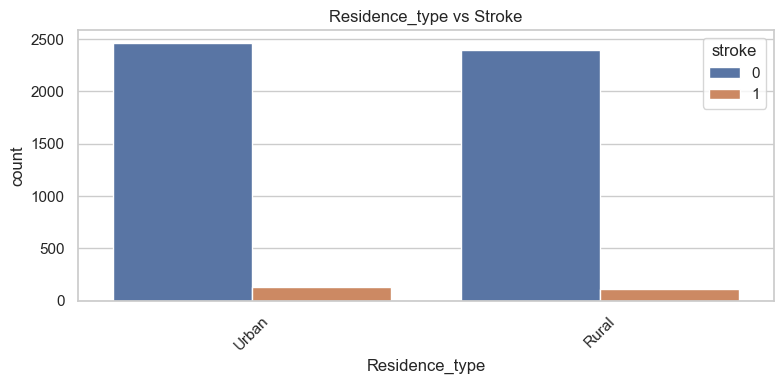

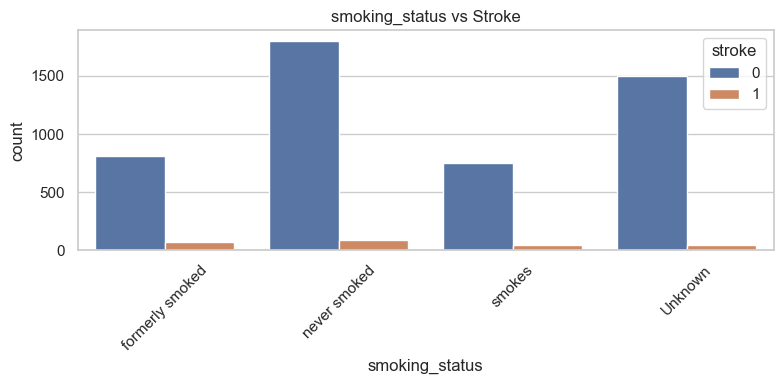

In [10]:
categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_vars:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f'{col} vs Stroke')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Se separa el set de entrenamiento, validación y test

Previo a las transformaciones y balanceo de los datos, se procede a crear una división entre los sets de entrenamiento, validación y test. StratifiedKFold hace los folds para validación de hiperparámetros. El set de validación se usa para encontrar el threshold óptimo y test para evaluar el modelo definitivo.

In [11]:
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']

# Primero: train + valid vs test
X_temp_rf, X_test_rf, y_temp_rf, y_test_rf = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.15/0.85, stratify=y_temp_rf)


# Transformaciones y tratamiento de Nulls

Con el objetivo de proveer datos numericos y validos al modelo de entrenamiento, utilizamos la media para rellenar los valores de BMI y most_frequent para las variables categoricas. Luego escalamos los valores numericos y aplicamos One-Hot encoding a las variables categoricas dado que tienen una baja cardinalidad.

In [12]:
df['bmi'] = df['bmi'].replace('N/A', np.nan).astype(float)

num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = ['gender', 'hypertension', 'heart_disease',
                'ever_married', 'Residence_type',
                'smoking_status', 'work_type']

# se imputan valores faltantes con median + escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# se imputan valores faltantes + One-Hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Random Forest
Características:
* Maneja naturalmente tanto variables numéricas como categóricas sin requerir transformaciones complejas.
* Captura relaciones no lineales entre variables clínicas (edad, glucosa, BMI, etc.) gracias a la estructura basada en múltiples árboles.
* Es un modelo robusto al ruido, a valores atípicos y a diferencias de escala entre las variables.
* Tolera bien el desbalance de clases mediante el parámetro class_weight='balanced', lo cual ayuda a no ignorar los casos positivos de stroke.
* Ofrece un buen compromiso entre interpretabilidad, precisión, robustez y capacidad de generalización.

In [13]:
# Modelo y pipeline

modelo_rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_rf)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_rf = {
    # cantidad de arboles
    'clf__n_estimators': [200, 400, 600],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10, 15],
    'clf__min_samples_leaf': [1, 2, 4, 6],
    # numero de features en cada split
    'clf__max_features': ['sqrt', 'log2'],
    # se agrega para castigar los falsos negativos, importante en algunos casos clinicos
    'clf__class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#probamos con 100 combinaciones aleatorias de parámetros
random_search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=parametros_rf,
    n_iter=200,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train_rf, y_train_rf)

print("Mejores hiperparámetros Random Forest:")
print(random_search_rf.best_params_)

best_rf = random_search_rf.best_estimator_

# Evaluación en VALIDACIÓN
y_pred_val = best_rf.predict(X_val_rf)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores hiperparámetros Random Forest:
{'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 6, 'clf__max_features': 'log2', 'clf__max_depth': 5, 'clf__class_weight': 'balanced'}


In [14]:
# Determinación del mejor umbral

y_proba_val_rf = best_rf.predict_proba(X_val_rf)[:, 1]

best_threshold, best_f2 = find_threshold(y_val_rf, y_proba_val_rf)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2:.4f}")

Mejor threshold en VALIDACIÓN: 0.586
F2 en VALIDACIÓN con ese threshold: 0.4195


In [15]:
# Se entrena el modelo y predecimos
y_proba_test_rf = best_rf.predict_proba(X_test_rf)[:, 1]
threshold_rf = best_threshold
y_pred_test_rf = (y_proba_test_rf >= threshold_rf).astype(int)

# KNN

En esta seccion se utiliza un clasificador KNN (K-nearest neighbors), por las siguientes razones:

* El problema es de clasificación binaria con variables tanto numéricas como categóricas. Aplicar KNN en este caso ya que tiene un enfoque que se apoya en la proximidad entre muestras cercanas y permite capturar patrones locales.
- KNN ofrece una interpretación intuitiva, puesto que el registro de un paciente nuevo se clasifica según el grupo de pacientes al que se parecen más sus características.

In [16]:
# Primero: train + valid vs test
X_temp_knn, X_test_knn, y_temp_knn, y_test_knn = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_temp_knn, y_temp_knn, test_size=0.15/0.85, stratify=y_temp_knn)


In [17]:
modelo_knn = KNeighborsClassifier()

pipe_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_knn)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2],                  # 1 = Manhattan, 2 = Euclídea
    'clf__leaf_size': [10, 20, 30, 40, 50],
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree']
}

cv_knn = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

random_search_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=parametros_grid_knn,
    n_iter=200,
    scoring=f2_scorer,
    cv=cv_knn,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_knn.fit(X_train_knn, y_train_knn)

best_knn = random_search_knn.best_estimator_

print("Mejores hiperparámetros KNN:")
print(random_search_knn.best_params_)

y_pred_val_knn = best_knn.predict(X_val_knn)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores hiperparámetros KNN:
{'clf__weights': 'uniform', 'clf__p': 2, 'clf__n_neighbors': 15, 'clf__leaf_size': 30, 'clf__algorithm': 'ball_tree'}


In [18]:
y_proba_val_knn = best_knn.predict_proba(X_val_knn)[:, 1]

best_threshold_knn, best_f2_knn = find_threshold(y_val_knn, y_proba_val_knn)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold_knn:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2_knn:.4f}")

y_proba_test_knn = best_knn.predict_proba(X_test_knn)[:, 1]
threshold = best_threshold_knn
y_pred_test_knn = (y_proba_test_knn >= threshold).astype(int)

Mejor threshold en VALIDACIÓN: 0.468
F2 en VALIDACIÓN con ese threshold: 0.3064


# CatBoost

In [28]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Primero: train + valid vs test
X_temp_cat, X_test_cat, y_temp_cat, y_test_cat = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_temp_cat, y_temp_cat, test_size=0.15/0.85, stratify=y_temp_cat)

#Inicializo CatBoost
modelo_catboost = CatBoostClassifier(
    random_state=41,
    verbose=True,
    allow_writing_files=False # para evitar la creación de carpetas catboost_info
)

pipe_cat = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_catboost)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_grid_cat = {
    # n_estimators -> iterations
    'clf__iterations': [100, 250, 400],
    # max_depth -> depth
    'clf__depth': [4, 6, 8],
    # learning_rate
    'clf__learning_rate': [0.01, 0.05, 0.1],
    # min_samples_leaf
    'clf__min_data_in_leaf': [1, 5, 10],
    # Regularización L2
    'clf__l2_leaf_reg': [1, 3, 5, 7],
    # Pesos
    'clf__class_weights': [{0: 1, 1: 3}, {0: 1, 1: 5}]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#probamos con 125 combinaciones aleatorias de parámetros
random_search_cat = RandomizedSearchCV(
    estimator=pipe_cat,
    param_distributions=parametros_grid_cat,
    n_iter=200,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


random_search_cat.fit(X_train_cat, y_train_cat)

best_cat = random_search_cat.best_estimator_

print("Mejores hiperparámetros XGBoost:")
print(random_search_cat.best_params_)

# Evaluación en VALIDACIÓN
y_pred_val = best_cat.predict(X_val_cat)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0:	learn: 0.6853489	total: 4.12ms	remaining: 1.64s
1:	learn: 0.6775593	total: 7.62ms	remaining: 1.52s
2:	learn: 0.6694210	total: 11ms	remaining: 1.46s
3:	learn: 0.6622462	total: 14.7ms	remaining: 1.46s
4:	learn: 0.6548653	total: 18.4ms	remaining: 1.45s
5:	learn: 0.6477977	total: 21.7ms	remaining: 1.42s
6:	learn: 0.6403688	total: 26.2ms	remaining: 1.47s
7:	learn: 0.6338417	total: 29.3ms	remaining: 1.44s
8:	learn: 0.6269933	total: 32.5ms	remaining: 1.41s
9:	learn: 0.6201301	total: 35.5ms	remaining: 1.38s
10:	learn: 0.6140002	total: 38.4ms	remaining: 1.36s
11:	learn: 0.6076427	total: 41.5ms	remaining: 1.34s
12:	learn: 0.6019034	total: 46.2ms	remaining: 1.38s
13:	learn: 0.5951338	total: 50ms	remaining: 1.38s
14:	learn: 0.5891660	total: 54.1ms	remaining: 1.39s
15:	learn: 0.5826038	total: 57.5ms	remaining: 1.38s
16:	learn: 0.5765935	total: 62ms	remaining: 1.4s
17:	learn: 0.5712431	total: 65.4ms	remaining: 1.39s
18:	learn: 0.5657

In [20]:
y_proba_val_cat = best_cat.predict_proba(X_val_cat)[:, 1]

best_threshold_cat, best_f2_cat = find_threshold(y_val_cat, y_proba_val_cat)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold_cat:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2_cat:.4f}")

y_proba_test_cat = best_cat.predict_proba(X_test_cat)[:, 1]
threshold = best_threshold_cat
y_pred_test_cat = (y_proba_test_cat >= threshold).astype(int)

Mejor threshold en VALIDACIÓN: 0.611
F2 en VALIDACIÓN con ese threshold: 0.3629


# XGBoost
Características:
* Es un modelo basado en árboles que maneja naturalmente relaciones no lineales entre las variables sin necesidad de ingeniería de features adicional.
* Suele obtener mejor rendimiento que Random Forest en datos tabulares gracias al boosting, que corrige iterativamente los errores de los árboles anteriores.
* Permite un control fino del sobreajuste mediante hiperparámetros como learning_rate, max_depth y gamma.
* Se adapta bien al desbalance de clases mediante el parámetro scale_pos_weight, y puede combinarse con SMOTE dentro del pipeline.
* Mantiene buena robustez frente a ruido y valores extremos

In [21]:
X_temp_xgb, X_test_xgb, y_temp_xgb, y_test_xgb = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_temp_xgb, y_temp_xgb, test_size=0.15/0.85, stratify=y_temp_xgb)

# Modelo y pipeline
modelo_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_xgb)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_grid_xgb = {
    'clf__n_estimators': [100, 200, 300, 500, 800],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.001, 0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__min_child_weight': [1, 3, 5],
    'clf__gamma': [0, 1, 3, 5],
    'clf__scale_pos_weight': [1, 3, 5, 10]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#probamos con 125 combinaciones aleatorias de parámetros
random_search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=parametros_grid_xgb,
    n_iter=200,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train_xgb, y_train_xgb)

best_xgb = random_search_xgb.best_estimator_

print("Mejores hiperparámetros XGBoost:")
print(random_search_xgb.best_params_)

# Evaluación en VALIDACIÓN
y_pred_val = best_xgb.predict(X_val_xgb)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores hiperparámetros XGBoost:
{'clf__subsample': 1.0, 'clf__scale_pos_weight': 1, 'clf__n_estimators': 200, 'clf__min_child_weight': 5, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__gamma': 0, 'clf__colsample_bytree': 0.6}


In [22]:
# Determinación del mejor umbral
y_proba_val_xgb = best_xgb.predict_proba(X_val_xgb)[:, 1]

best_threshold_xgb, best_f2_xgb = find_threshold(y_val_xgb, y_proba_val_xgb)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold_xgb:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2_xgb:.4f}")

# Se entrena el modelo y predecimos
y_proba_test_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]
threshold = best_threshold_xgb
y_pred_test_xgb = (y_proba_test_xgb >= threshold).astype(int)

Mejor threshold en VALIDACIÓN: 0.502
F2 en VALIDACIÓN con ese threshold: 0.3655


# METRICAS COMPARATIVAS

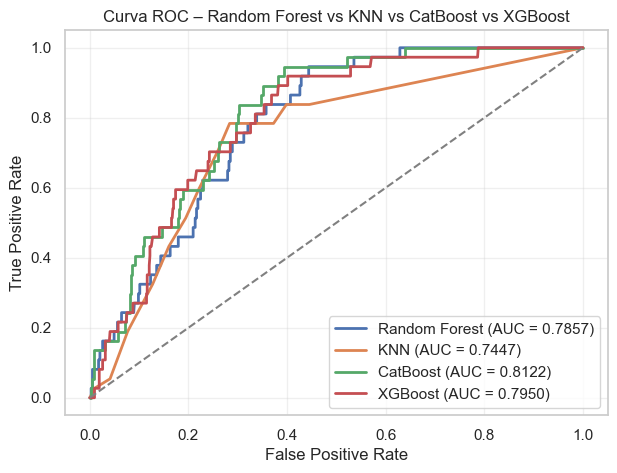

In [23]:
# Cálculo ROC de Random Forest
roc_auc_rf = roc_auc_score(y_test_rf, y_proba_test_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_proba_test_rf)

# Cálculo ROC de KNN
roc_auc_knn = roc_auc_score(y_test_knn, y_proba_test_knn)
fpr_knn, tpr_knn, _ = roc_curve(y_test_knn, y_proba_test_knn)

# Cálculo ROC de CatBoost
roc_auc_cat = roc_auc_score(y_test_cat, y_proba_test_cat)
fpr_cat, tpr_cat, _ = roc_curve(y_test_cat, y_proba_test_cat)

# Cálculo ROC de XGBoost
roc_auc_xgb = roc_auc_score(y_test_xgb, y_proba_test_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_xgb, y_proba_test_xgb)

plt.figure(figsize=(7, 5))

# RF
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", linewidth=2)

# RF
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_knn:.4f})", linewidth=2)

# RF
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {roc_auc_cat:.4f})", linewidth=2)

# XGB
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})", linewidth=2)

# Diagonal
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Random Forest vs KNN vs CatBoost vs XGBoost")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

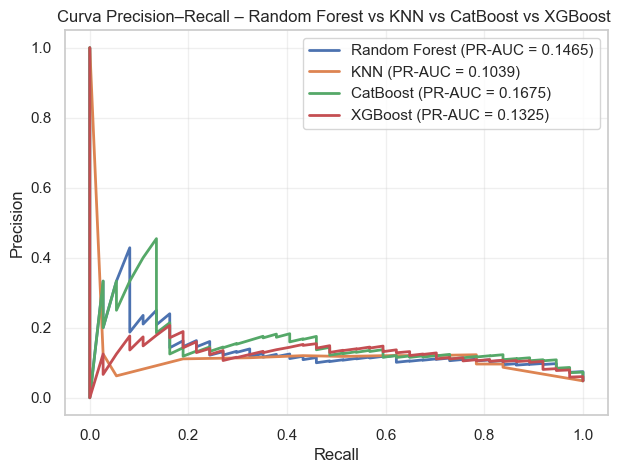

In [24]:
# PR Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test_rf, y_proba_test_rf)
pr_auc_rf = average_precision_score(y_test_rf, y_proba_test_rf)

# PR KNN
precision_knn, recall_knn, _ = precision_recall_curve(y_test_knn, y_proba_test_knn)
pr_auc_knn = average_precision_score(y_test_knn, y_proba_test_knn)

# PR CatBoost
precision_cat, recall_cat, _ = precision_recall_curve(y_test_cat, y_proba_test_cat)
pr_auc_cat = average_precision_score(y_test_cat, y_proba_test_cat)

# PR XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test_xgb, y_proba_test_xgb)
pr_auc_xgb = average_precision_score(y_test_xgb, y_proba_test_xgb)

plt.figure(figsize=(7, 5))

plt.plot(recall_rf, precision_rf, label=f"Random Forest (PR-AUC = {pr_auc_rf:.4f})", linewidth=2)
plt.plot(recall_knn, precision_knn, label=f"KNN (PR-AUC = {pr_auc_knn:.4f})", linewidth=2)
plt.plot(recall_cat, precision_cat, label=f"CatBoost (PR-AUC = {pr_auc_cat:.4f})", linewidth=2)
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (PR-AUC = {pr_auc_xgb:.4f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall – Random Forest vs KNN vs CatBoost vs XGBoost ")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

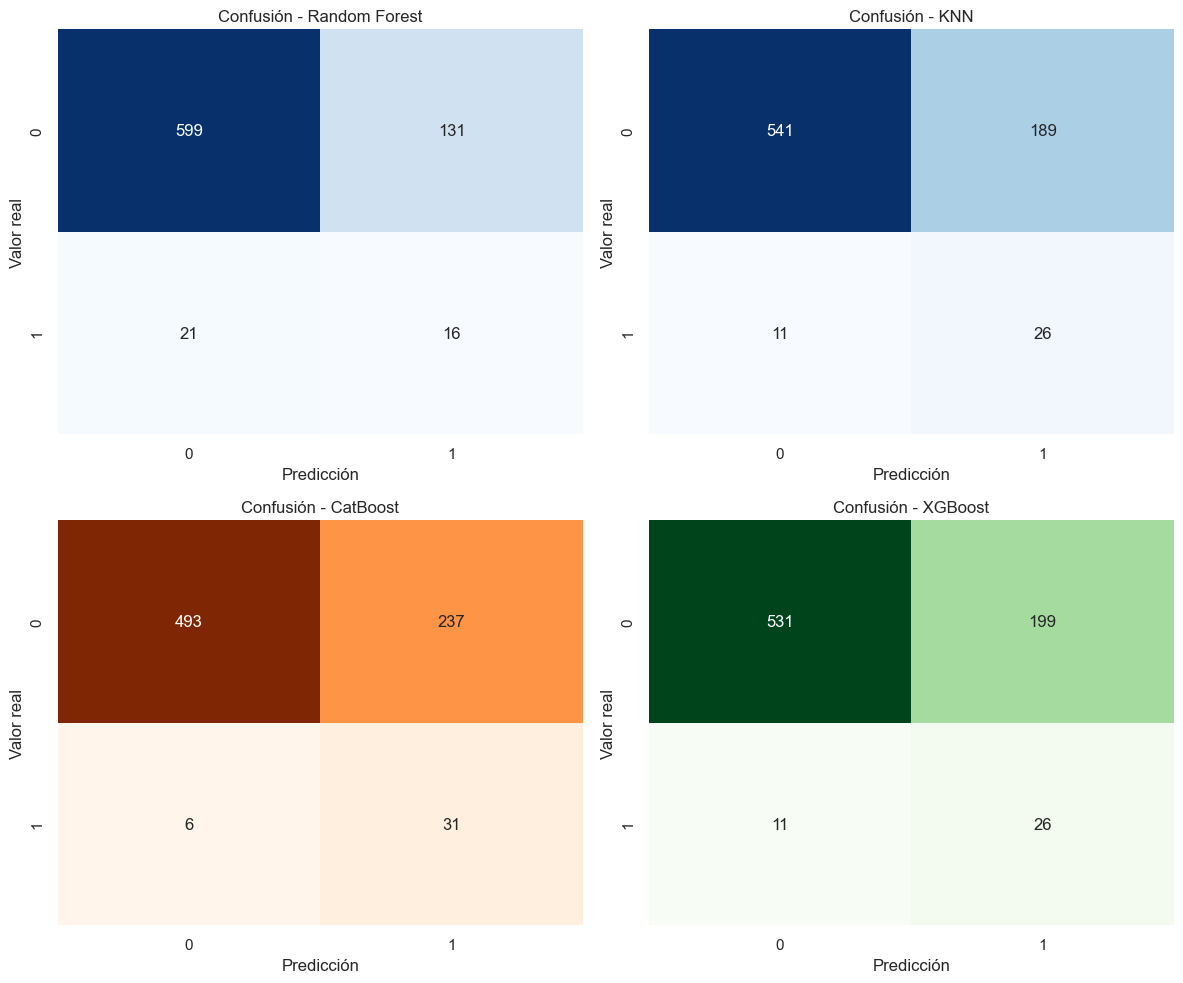

In [25]:
# Matrices de confusión
cm_rf = confusion_matrix(y_test_rf, y_pred_test_rf)
cm_knn = confusion_matrix(y_test_knn, y_pred_test_knn)
cm_cat = confusion_matrix(y_test_cat, y_pred_test_cat)
cm_xgb = confusion_matrix(y_test_xgb, y_pred_test_xgb)

# Crear figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0, 0])
axes[0, 0].set_title("Confusión - Random Forest")
axes[0, 0].set_xlabel("Predicción")
axes[0, 0].set_ylabel("Valor real")

# KNN
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0, 1])
axes[0, 1].set_title("Confusión - KNN")
axes[0, 1].set_xlabel("Predicción")
axes[0, 1].set_ylabel("Valor real")

# CatBoost
sns.heatmap(cm_cat, annot=True, fmt="d", cmap="Oranges", cbar=False, ax=axes[1, 0])
axes[1, 0].set_title("Confusión - CatBoost")
axes[1, 0].set_xlabel("Predicción")
axes[1, 0].set_ylabel("Valor real")

# XGBoost
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1, 1])
axes[1, 1].set_title("Confusión - XGBoost")
axes[1, 1].set_xlabel("Predicción")
axes[1, 1].set_ylabel("Valor real")

plt.tight_layout()
plt.show()


# METRICAS COMPARATIVAS

In [26]:
def regression_metrics(y_true, y_proba):
    mae = mean_absolute_error(y_true, y_proba)
    rmse = np.sqrt(mean_squared_error(y_true, y_proba))

    # MAPE: evitar división por cero
    eps = 1e-6
    mape = np.mean(np.abs((y_true - y_proba) / (y_true + eps))) * 100

    r2 = r2_score(y_true, y_proba)

    return mae, rmse, mape, r2

metrics_rf  = regression_metrics(y_test_rf,  y_proba_test_rf)
metrics_knn = regression_metrics(y_test_knn, y_proba_test_knn)
metrics_cat = regression_metrics(y_test_cat, y_proba_test_cat)
metrics_xgb = regression_metrics(y_test_xgb, y_proba_test_xgb)

df_metrics = pd.DataFrame(
    [metrics_rf, metrics_knn, metrics_cat, metrics_xgb],
    columns=["MAE", "RMSE", "MAPE (%)", "R²"],
    index=["Random Forest", "KNN", "CatBoost", "XGBoost"]
)

df_metrics


,MAE,RMSE,MAPE (%),R²
Random Forest,0.302408,0.381952,2.797417e+07,-2.177492
KNN,0.254150,0.414820,2.332030e+07,-2.747885
CatBoost,0.343678,0.478335,3.307731e+07,-3.983455
XGBoost,0.324755,0.392374,3.035022e+07,-2.353256


# Que pasa si calibramos RF?


Mejor threshold (calibrado) en VALIDACIÓN: 0.0986
Mejor F2 en VALIDACIÓN (calibrado): 0.4392

=== Random Forest calibrado - MÉTRICAS EN TEST ===
ROC-AUC        : 0.7800
PR-AUC         : 0.1428
Brier score    : 0.0441

Reporte de clasificación (umbral calibrado):
              precision    recall  f1-score   support

           0     0.9662    0.8219    0.8882       730
           1     0.1096    0.4324    0.1749        37

    accuracy                         0.8031       767
   macro avg     0.5379    0.6272    0.5315       767
weighted avg     0.9249    0.8031    0.8538       767

Matriz de confusión (umbral calibrado):
[[600 130]
 [ 21  16]]


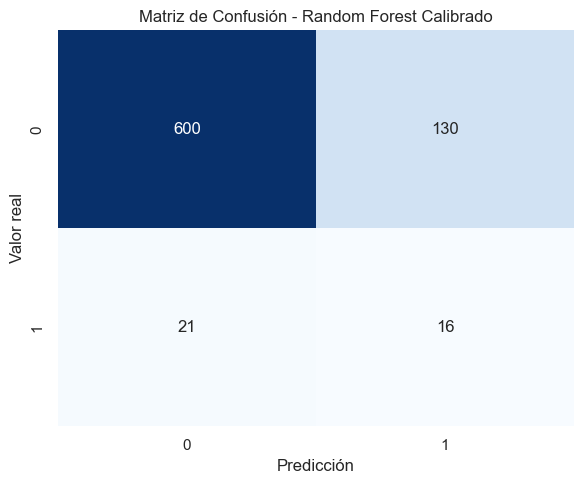

In [27]:
rf_cal = CalibratedClassifierCV(
    estimator=best_rf,   # tu pipeline preprocessor + smote + RF
    cv=5,
    method='sigmoid'
)

# calibramos solo con el TRAIN para evitar leakage
rf_cal.fit(X_train_rf, y_train_rf)

y_proba_val_cal = rf_cal.predict_proba(X_val_rf)[:, 1]

best_threshold_cal, best_f2_cal = find_threshold(y_val_rf, y_proba_val_cal)

print(f"\nMejor threshold (calibrado) en VALIDACIÓN: {best_threshold_cal:.4f}")
print(f"Mejor F2 en VALIDACIÓN (calibrado): {best_f2_cal:.4f}")

y_proba_test_cal = rf_cal.predict_proba(X_test_rf)[:, 1]
y_pred_test_cal  = (y_proba_test_cal >= best_threshold_cal).astype(int)

roc_auc_cal  = roc_auc_score(y_test_rf, y_proba_test_cal)
pr_auc_cal   = average_precision_score(y_test_rf, y_proba_test_cal)
brier_cal    = brier_score_loss(y_test_rf, y_proba_test_cal)

print("\n=== Random Forest calibrado - MÉTRICAS EN TEST ===")
print(f"ROC-AUC        : {roc_auc_cal:.4f}")
print(f"PR-AUC         : {pr_auc_cal:.4f}")
print(f"Brier score    : {brier_cal:.4f}")

print("\nReporte de clasificación (umbral calibrado):")
print(classification_report(y_test_rf, y_pred_test_cal, digits=4, zero_division=0))

cm_cal = confusion_matrix(y_test_rf, y_pred_test_cal)

print("Matriz de confusión (umbral calibrado):")
print(cm_cal)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_cal, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión - Random Forest Calibrado")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.tight_layout()
plt.show()

## Conclusión

El objetivo del trabajo fue construir y evaluar distintos modelos de Machine Learning capaces de predecir la probabilidad de ocurrencia de un accidente cerebrovascular (ACV) a partir de variables demográficas y clínicas. El dataset presenta un fuerte desbalance de clases (aproximadamente 95% negativos y 5% positivos), lo que dificulta la detección de casos reales y aumenta el riesgo de falsos negativos. En un contexto clínico, donde omitir un caso positivo puede impedir una intervención temprana, se priorizó maximizar el recall incluso a costa de incrementar los falsos positivos.

#### Preparación y Preprocesamiento

- Se imputaron valores faltantes tanto en variables numéricas como categóricas.
- Se aplicó estandarización y One-Hot encoding.
- Se incorporó SMOTE únicamente dentro del conjunto de entrenamiento para evitar data leakage.
- Se evaluaron múltiples configuraciones de class_weight para compensar el desbalance.
- Se separó estrictamente entre train, valid y test para una evaluación honesta.

#### Entrenamiento, tuning y calibración

El modelo principal utilizado fue Random Forest, comparado contra KNN, CatBoost y XGBoost.
La búsqueda de hiperparámetros se realizó mediante RandomizedSearchCV, empleando F2-score como métrica objetivo para priorizar la reducción de falsos negativos.
Posteriormente, se identificó el threshold óptimo utilizando el conjunto de validación.

Se aplicó calibración mediante CalibratedClassifierCV con método sigmoid (Platt scaling). Si bien esta técnica mejora la calidad de las probabilidades (medida por Brier score), no garantiza mejorar recall, especialmente en datasets con clases extremadamente desbalanceadas.

#### Comparación entre modelos

- **Random Forest** fue el modelo más equilibrado y con mejor recall.
- **CatBoost** mostró buen rendimiento global, pero produjo más falsos positivos.
- **XGBoost** tuvo buen AUC pero menos estabilidad.
- **KNN** fue el más débil en discriminación y sensibilidad.
- Ningún modelo presentó buena calibración de probabilidades (MAE, RMSE y R² bajos), lo cual es esperado en problemas con clases muy desbalanceadas.

## Conclusión final

El modelo más adecuado para el objetivo planteado maximizar la detección de posibles ACV y minimizar falsos negativos fue Random Forest sin calibrar, utilizando:

- Datos balanceados con SMOTE
- Optimización para F2
- Threshold ajustado mediante validación

Aunque la calibración redujo el error probabilístico, perjudicó la sensibilidad del modelo y aumentó los falsos negativos. Por ello, la versión calibrada no es la recomendada para este caso.

En conclusión, Random Forest optimizado y con umbral ajustado es la mejor elección para este problema clínico, logrando el mejor equilibrio entre recall, estabilidad y coherencia con el objetivo del estudio.